# Neural networks

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import * 
from IPython.display import Image, display_svg, SVG
import numpy as np
from sklearn.metrics import root_mean_squared_error
 
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8


In [2]:
path = Path('../../..')
Path.BASE_PATH = path


In [3]:
wdf_2016 = pd.read_csv(path/'data/processed/Onsite-MetMast-SCADA-data-2016.csv', low_memory = False)
wdf_2017 = pd.read_csv(path/'data/processed/Onsite-MetMast-SCADA-data-2017.csv', low_memory=False)
tdf_2016 = pd.read_csv(path/'data/processed/Wind-Turbine-SCADA-signals-2016.csv',low_memory = False)
tdf_2017 = pd.read_csv(path/'data/processed/Wind-Turbine-SCADA-signals-2017_0.csv', low_memory=False)

df_2016 = pd.merge(wdf_2016, tdf_2016, on='Timestamp', how='outer')
df_2017 = pd.merge(wdf_2017, tdf_2017, on='Timestamp', how='outer')

# Using pandas boolean indexing to create new dataframe where Turbine ID = T07
df_2016_T07 = df_2016[df_2016['Turbine_ID']=='T07'].copy().reset_index(drop=True)
df_2017_T07 = df_2017[df_2017['Turbine_ID']=='T07'].copy().reset_index(drop=True)



In [4]:
#df_train_and_val = pd.concat([df_2016_T07, df_2017_T07])

In [5]:
training_percentage = 0.66 # split is 33% training data, 17% validation data and 50% test data like in Olivers rapport. 66% training here because we only use 2016 dataset for test/validation
split_index = int(len(df_2016_T07) * training_percentage)

# split dataframe
train = df_2016_T07.iloc[:split_index].index
validation = df_2016_T07.iloc[split_index:].index

splits = (list(train), list(validation))

In [6]:
valid_xs_final = load_pickle(path/'models/final_data_val.pkl') #validation set after datacleaning (haven't removed faulty sensordata)
xs_final = load_pickle(path/'models/final_data_train.pkl') # training set after datacleaning (haven't removed faulty sensordata)



In [7]:
dep_var = "Gen_Bear_Temp_Avg"

In [8]:
df_2016_T07, df_2017_T07 = add_datepart(df_2016_T07, 'Timestamp', drop=False), add_datepart(df_2017_T07, 'Timestamp',drop=False)

/Users/Magnus1/Documents/GitHub/DAT255-group12/.venv/lib/python3.11/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
/Users/Magnus1/Documents/GitHub/DAT255-group12/.venv/lib/python3.11/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [9]:
#TODO: change to use xs_final_time which we got from removing out-of-domain data in 5_interpreting_results.ipynb

df_nn_final = df_2016_T07[list(xs_final.columns) + [dep_var]]
df_2017_T07_copy = df_2017_T07[list(xs_final.columns) + [dep_var]]

Categorical columns are handled very differently in neural networks, compared to decision tree approaches. As we saw in <<chapter_collab>>, in a neural net a great way to handle categorical variables is by using embeddings. To create embeddings, fastai needs to determine which columns should be treated as categorical variables. It does this by comparing the number of distinct levels in the variable to the value of the `max_card` parameter. If it's lower, fastai will treat the variable as categorical. Embedding sizes larger than 10,000 should generally only be used after you've tested whether there are better ways to group the variable, so we'll use 9,000 as our `max_card`:

In [10]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [11]:
cont_nn

['Gen_Bear2_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Grd_Busbar_Temp_Avg',
 'Cont_VCP_ChokcoilTemp_Avg',
 'Gear_Oil_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'Gen_SlipRing_Temp_Avg',
 'Cont_Top_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg']

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

In [12]:
df_nn_final[cat_nn].nunique()

Series([], dtype: float64)

Vi har ingen kategoridata.. Men hvis vi har det kan det være greit å scrolle ned til denne delen av fastbook chapter 9 for å se hvordan man håndterer det

Videre må vi normalisere dataen for det nevrale nettverket.

In [13]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn
                    , splits=splits, y_names=dep_var)

In [14]:
dls = to_nn.dataloaders(1024)

In [15]:
y = to_nn.train.y
y.min(),y.max()

(19.0, 204.0)

In [16]:
learn = tabular_learner(dls,y_range=(19,120),layers=[500,250],
                        n_out=1,loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002290867705596611)

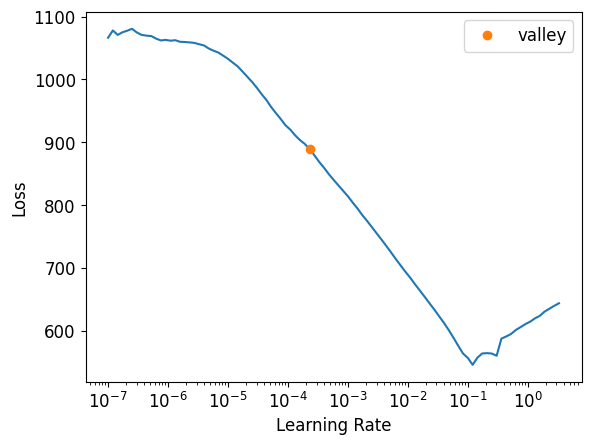

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,time
0,379.327637,58.970024,00:02
1,163.900665,35.951279,00:02
2,76.070755,15.635407,00:02
3,40.111248,14.801459,00:02
4,23.196201,3.527318,00:02


In [19]:
preds,targs = learn.get_preds()

print(f'root mean square error: {root_mean_squared_error(preds,targs)}')

root mean square error: 1.8781155347824097


RMSE ligger over den av random forest. Må kanskje tweake hyperparametre og rydde mer i datasettet for at denne skal bli like bra?

In FastAI, you can create a new DataLoaders object with your test set and then use the test_dl method of the Learner to create a test DataLoader.

In [20]:
test_dl = learn.dls.test_dl(df_2017_T07_copy)

In [21]:
preds, _= learn.get_preds(dl=test_dl)

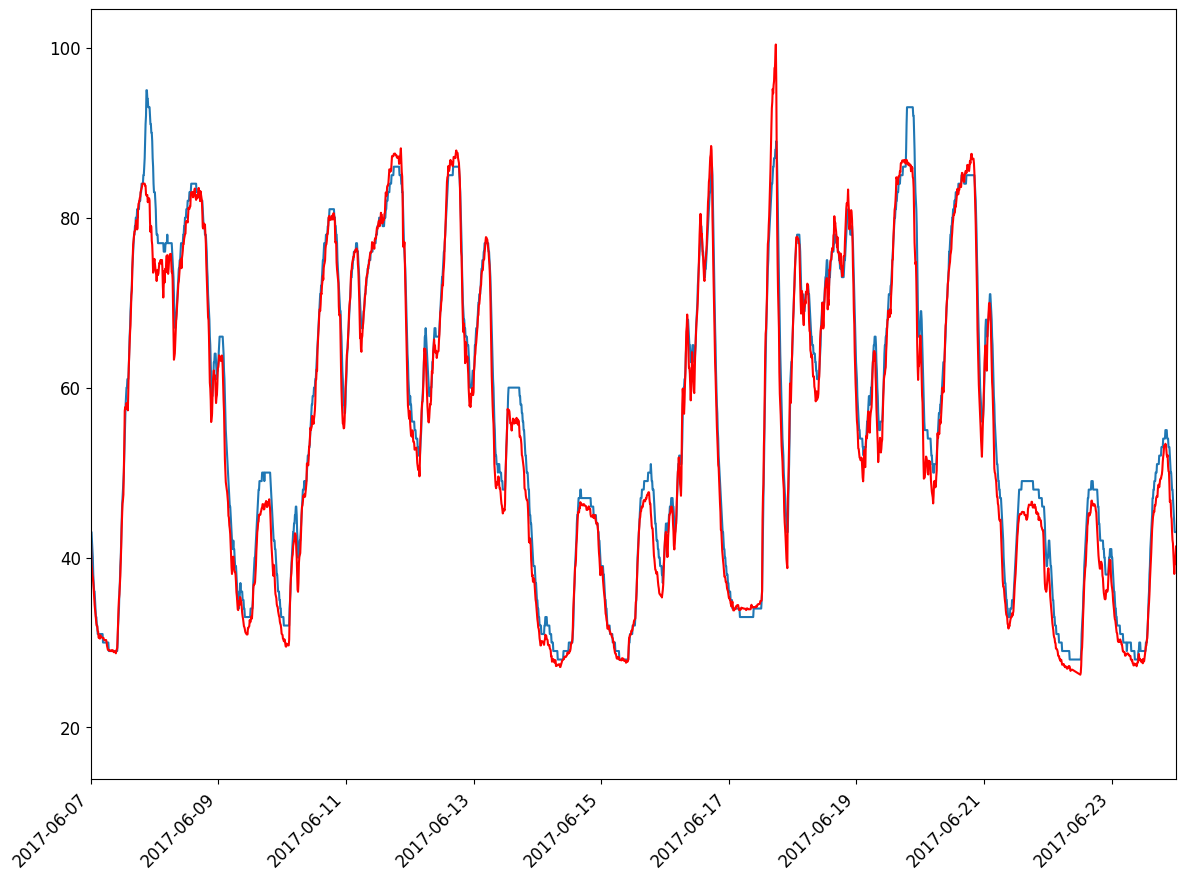

In [22]:
plt.figure(figsize=(14,10))
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.Timestamp('2017-06-07'), pd.Timestamp('2017-06-24'))
plt.plot(df_2017_T07['Timestamp'],df_2017_T07[dep_var])
plt.plot(df_2017_T07['Timestamp'],preds, color='r')
